# Linear regression

Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from matplotlib import rcParams
from yellowbrick.regressor import ResidualsPlot
from sklearn.svm import SVR
from scipy.stats import normaltest
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set_context('talk')
sns.set_style('darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

### Data downloading:

In [2]:
data = pd.read_table(
    "https://raw.githubusercontent.com/DSmentor/EPAM_SPb_DS_course_files/master/2.Regression/AirQualityUCI.csv",
    sep=";",
    na_values=-200,
    decimal=",",
)
data.head()
data.shape

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


(9471, 17)

Ratio of non-missing values in every column:

In [3]:
data.count() / data.shape[0]

Date             0.987963
Time             0.987963
CO(GT)           0.810263
PT08.S1(CO)      0.949319
NMHC(GT)         0.096505
C6H6(GT)         0.949319
PT08.S2(NMHC)    0.949319
NOx(GT)          0.814909
PT08.S3(NOx)     0.949319
NO2(GT)          0.814592
PT08.S4(NO2)     0.949319
PT08.S5(O3)      0.949319
T                0.949319
RH               0.949319
AH               0.949319
Unnamed: 15      0.000000
Unnamed: 16      0.000000
dtype: float64

<Axes: >

Text(0.5, 1.0, 'Visualization of NAs in dataset (white - missing values)\n')

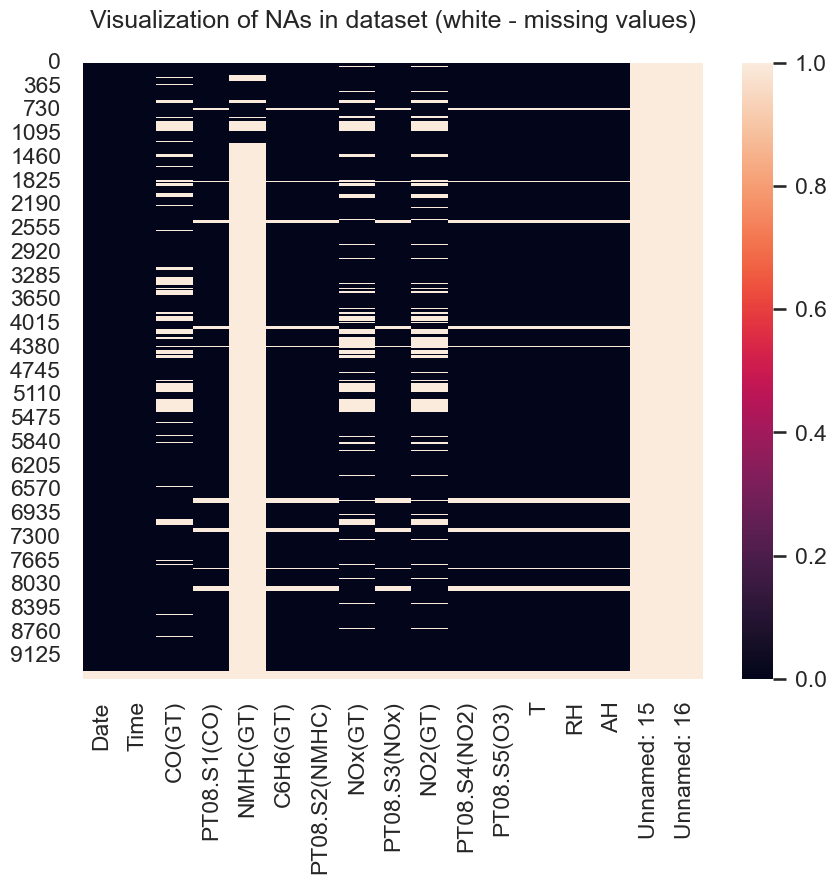

In [4]:
sns.heatmap(data.isna())
plt.title("Visualization of NAs in dataset (white - missing values)\n")

### Data preparation

__Problems to solve__:
1. Two last columns are all NaNs (`Unnamed: 15`, `Unnamed: 16`);
2. One column contains only 1% of non-missing values (`NMHC(GT)`);
3. `Date` and `Time` columns can be set as an index (pd.DateTimeIndex).

In [5]:
data.drop(["Unnamed: 15", "Unnamed: 16", "NMHC(GT)"], axis=1, inplace=True)

#### Parse Date and Time columns

In [7]:
data.Time = data.Time.str.replace(".", ":")
data.Date = data["Date"] + " " + data["Time"]
data.Date = pd.to_datetime(data.Date, infer_datetime_format=True)
data = data.set_index("Date")
data.drop(["Time"], axis=1, inplace=True)

/var/folders/sx/s2q0vz2d1mv8hq3w30ss93l40000gn/T/ipykernel_15218/2629602872.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data.Date = pd.to_datetime(data.Date, infer_datetime_format=True)
/var/folders/sx/s2q0vz2d1mv8hq3w30ss93l40000gn/T/ipykernel_15218/2629602872.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.Date = pd.to_datetime(data.Date, infer_datetime_format=True)


In [ ]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004 18:00:00,18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004 19:00:00,19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004 20:00:00,20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004 21:00:00,21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004 22:00:00,22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Now let's see if there were some 'bad days', that contain mostly missing values:

In [ ]:
print(
    "Maximum number of missing values = number of columns in df = {}".format(
        len(data.columns)
    )
)

Maximum number of missing values = number of columns in df = 14


Remove rows that have more than 10 missing values:

In [ ]:
bad_rows = data[data.shape[1] - data.count(axis=1) > 10].index
data.drop(bad_rows, axis=0, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9313 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9313 non-null   object 
 1   Time           9313 non-null   object 
 2   CO(GT)         7661 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   C6H6(GT)       8991 non-null   float64
 5   PT08.S2(NMHC)  8991 non-null   float64
 6   NOx(GT)        7718 non-null   float64
 7   PT08.S3(NOx)   8991 non-null   float64
 8   NO2(GT)        7715 non-null   float64
 9   PT08.S4(NO2)   8991 non-null   float64
 10  PT08.S5(O3)    8991 non-null   float64
 11  T              8991 non-null   float64
 12  RH             8991 non-null   float64
 13  AH             8991 non-null   float64
dtypes: float64(12), object(2)
memory usage: 1.1+ MB


Also, there're some missing values in target variable. There's nothing we can do, so just remove those rows:

In [ ]:
data.drop(data[data["C6H6(GT)"].isnull()].index, axis=0, inplace=True)

Final data shape:

In [ ]:
data.shape

(8991, 14)

### Train/Test split

We have time-dependent data set. In order to perform validation we need to predict future by using past:  
so first 8000 rows will be __train__ and last ~2000 will be __test__

In [ ]:
data = data.sort_index()
train, test = data.iloc[:8000, :], data.iloc[8000:, :]

### __Filling NA's__

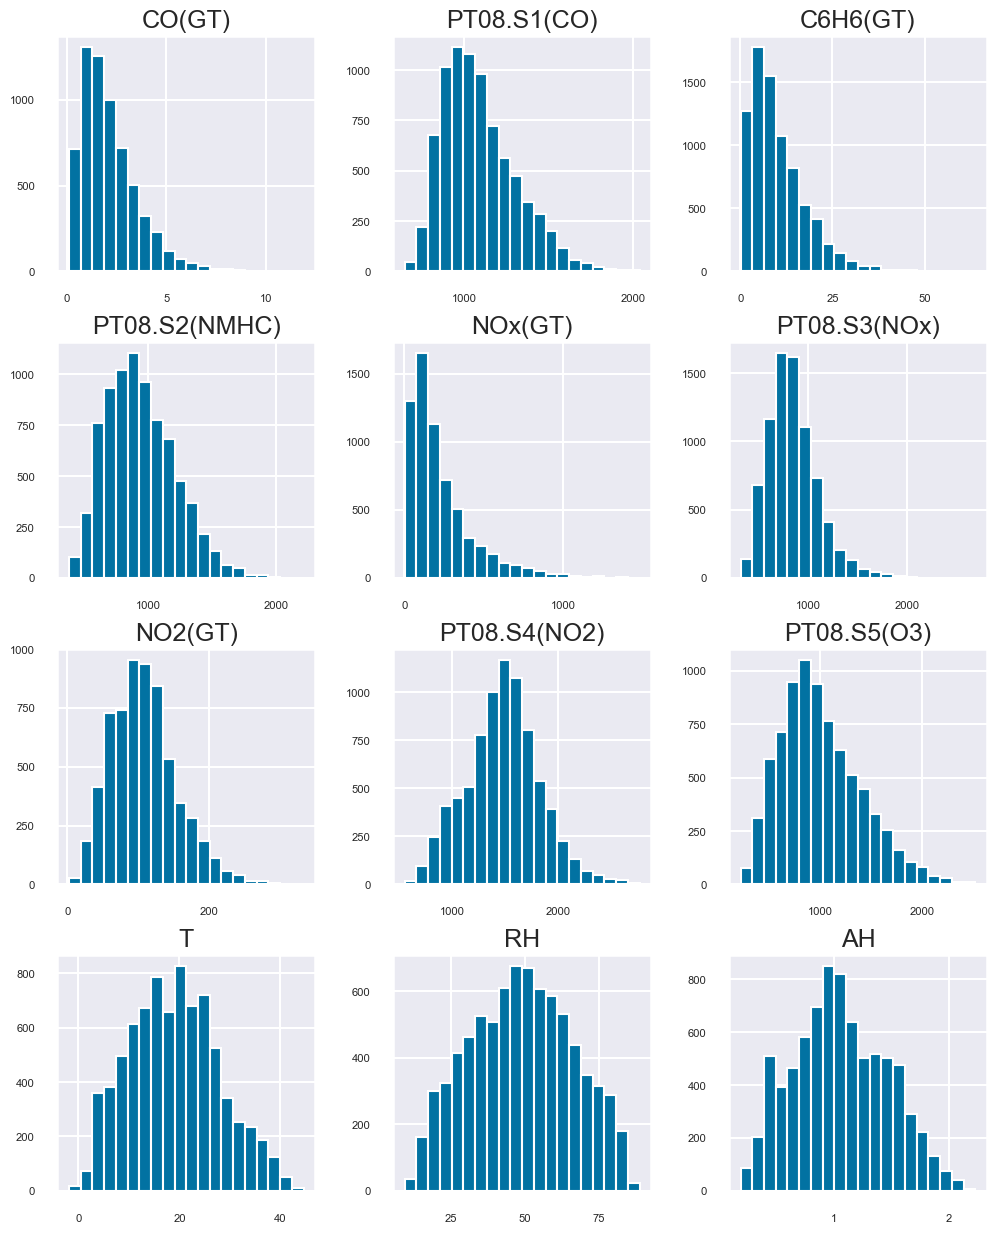

In [ ]:
train.hist(figsize=(12, 15), bins=20, xlabelsize=8, ylabelsize=8)

We see, that some of variables' distributions are skewed, so to fill NAs with _medians_ would be the best strategy.
We'll save medians in train df for future use in test df:

In [ ]:
to_fill = {}
for i in train.columns:
    to_fill[i] = np.nanmedian(train[i])
train = train.fillna(value=to_fill)
train.count() / train.shape[0]

CO(GT)           1.0
PT08.S1(CO)      1.0
C6H6(GT)         1.0
PT08.S2(NMHC)    1.0
NOx(GT)          1.0
PT08.S3(NOx)     1.0
NO2(GT)          1.0
PT08.S4(NO2)     1.0
PT08.S5(O3)      1.0
T                1.0
RH               1.0
AH               1.0
dtype: float64

### EDA

This data has to be scaled:

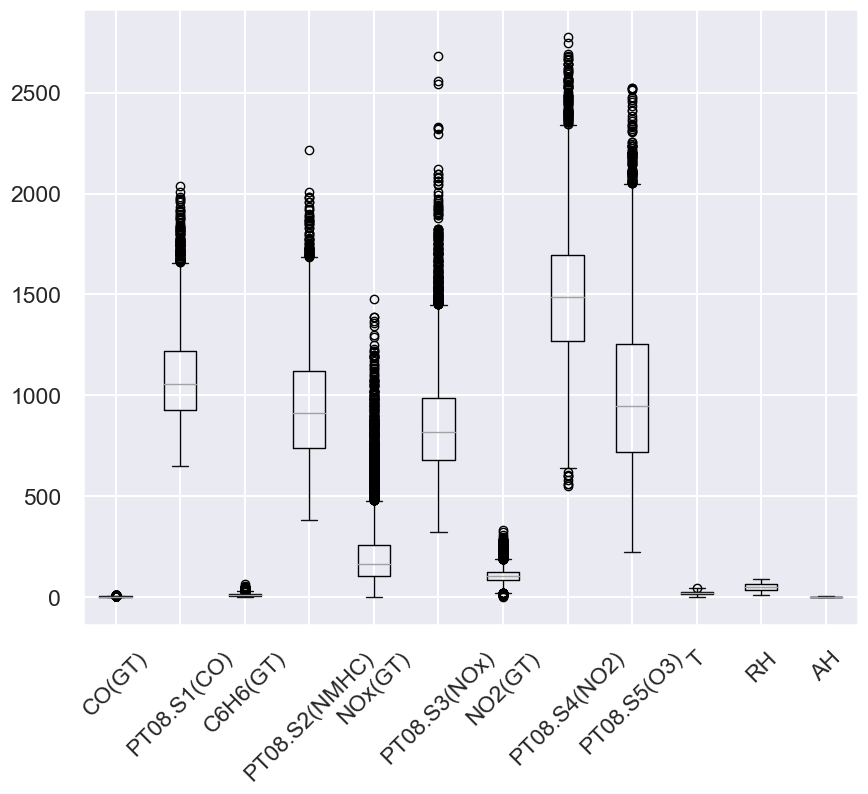

In [ ]:
train.boxplot(rot=45)

Let's look at target feature:

C:\Users\Emre_Ozden\AppData\Local\Temp\ipykernel_15772\838951371.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train['C6H6(GT)'], norm_hist=True)


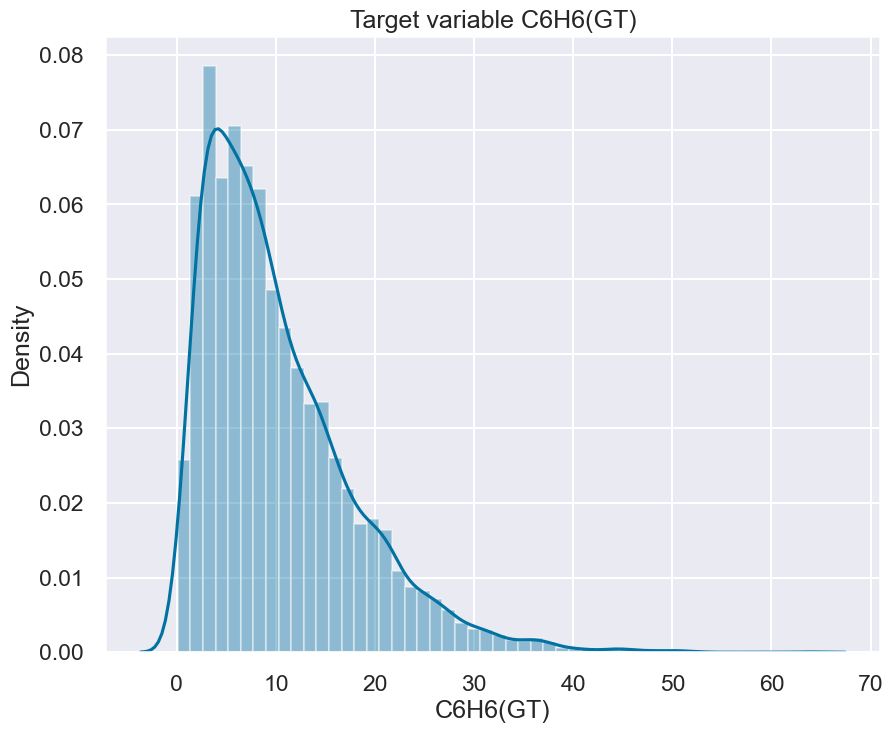

In [ ]:
ax = sns.distplot(train["C6H6(GT)"], norm_hist=True)
ax.set_title("Target variable C6H6(GT)")

It is skewed. May be logarithmic scale will make a deal:

C:\Users\Emre_Ozden\AppData\Local\Temp\ipykernel_15772\2999277349.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(np.log2(train['C6H6(GT)']), norm_hist=True)


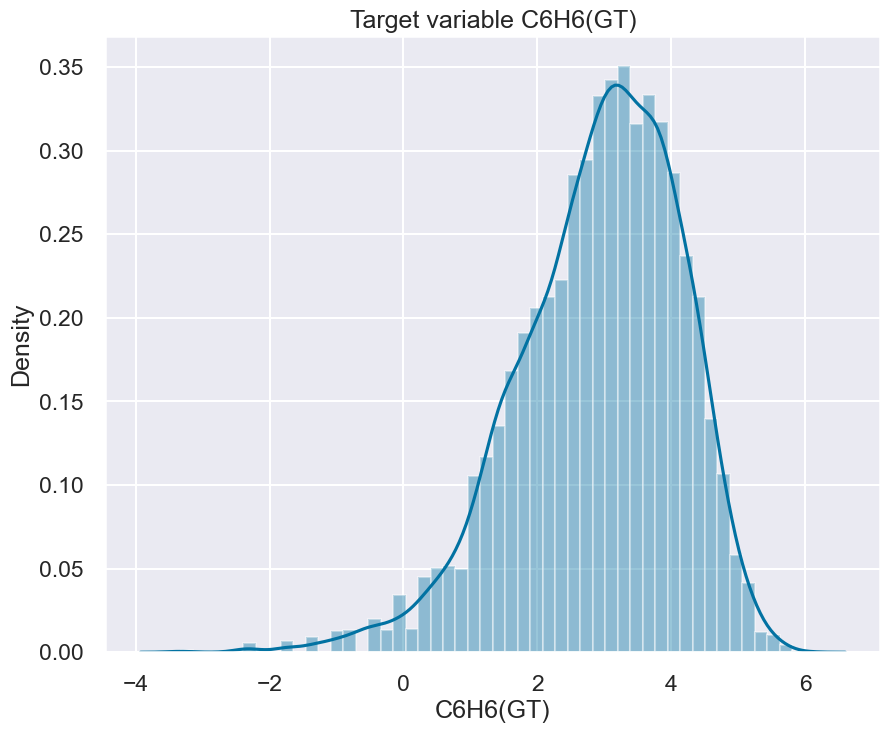

In [ ]:
ax = sns.distplot(np.log2(train["C6H6(GT)"]), norm_hist=True)
ax.set_title("Target variable C6H6(GT)")

A little bit better

### Pairwise correlation:
* Select features which are highly correlated with target
* Draw a pairplot
* Select those features for future use

It is clear that some features have very high correlation coefficient with target (PT08.S2(NMHC) ~ C6H6(GT)!)  
So for future analysis we need to drop features with low correlation with target, otherwise they will bring noize to our model:

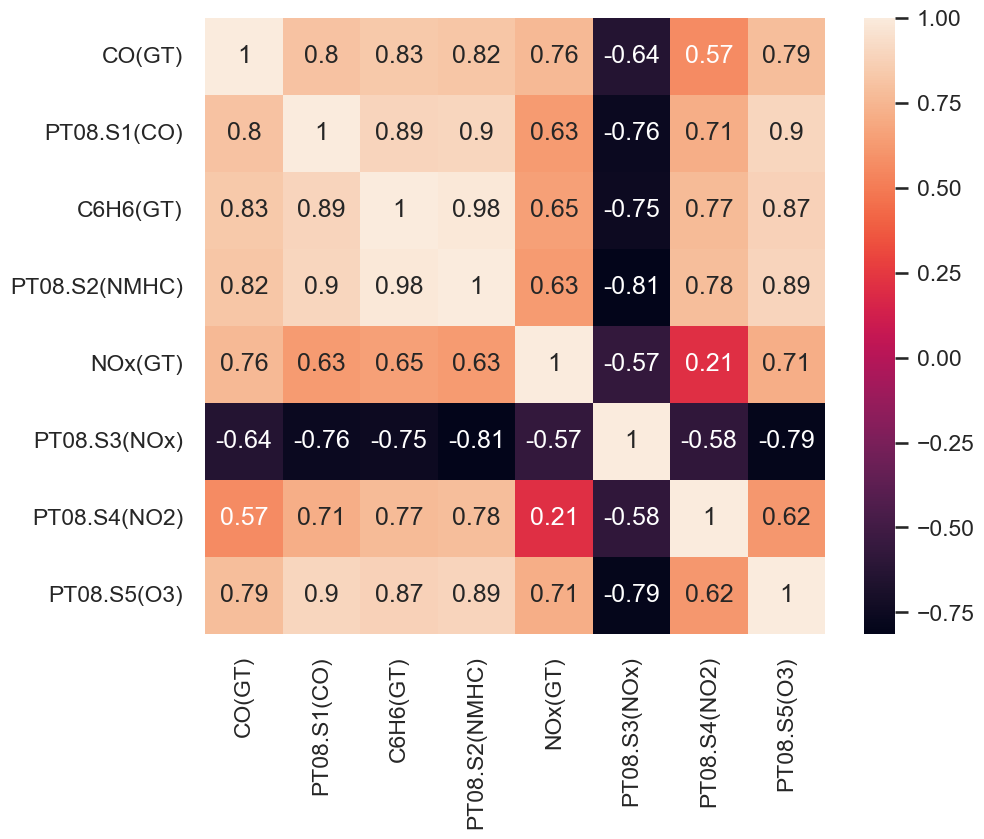

In [ ]:
corr = train.corr()
condition = np.absolute(corr["C6H6(GT)"]) > 0.6
top_corr = corr.loc[condition, condition]
data_top_corr = train.loc[:, top_corr.columns]
sns.heatmap(top_corr, annot=True)

Visualize pairwise correlation:

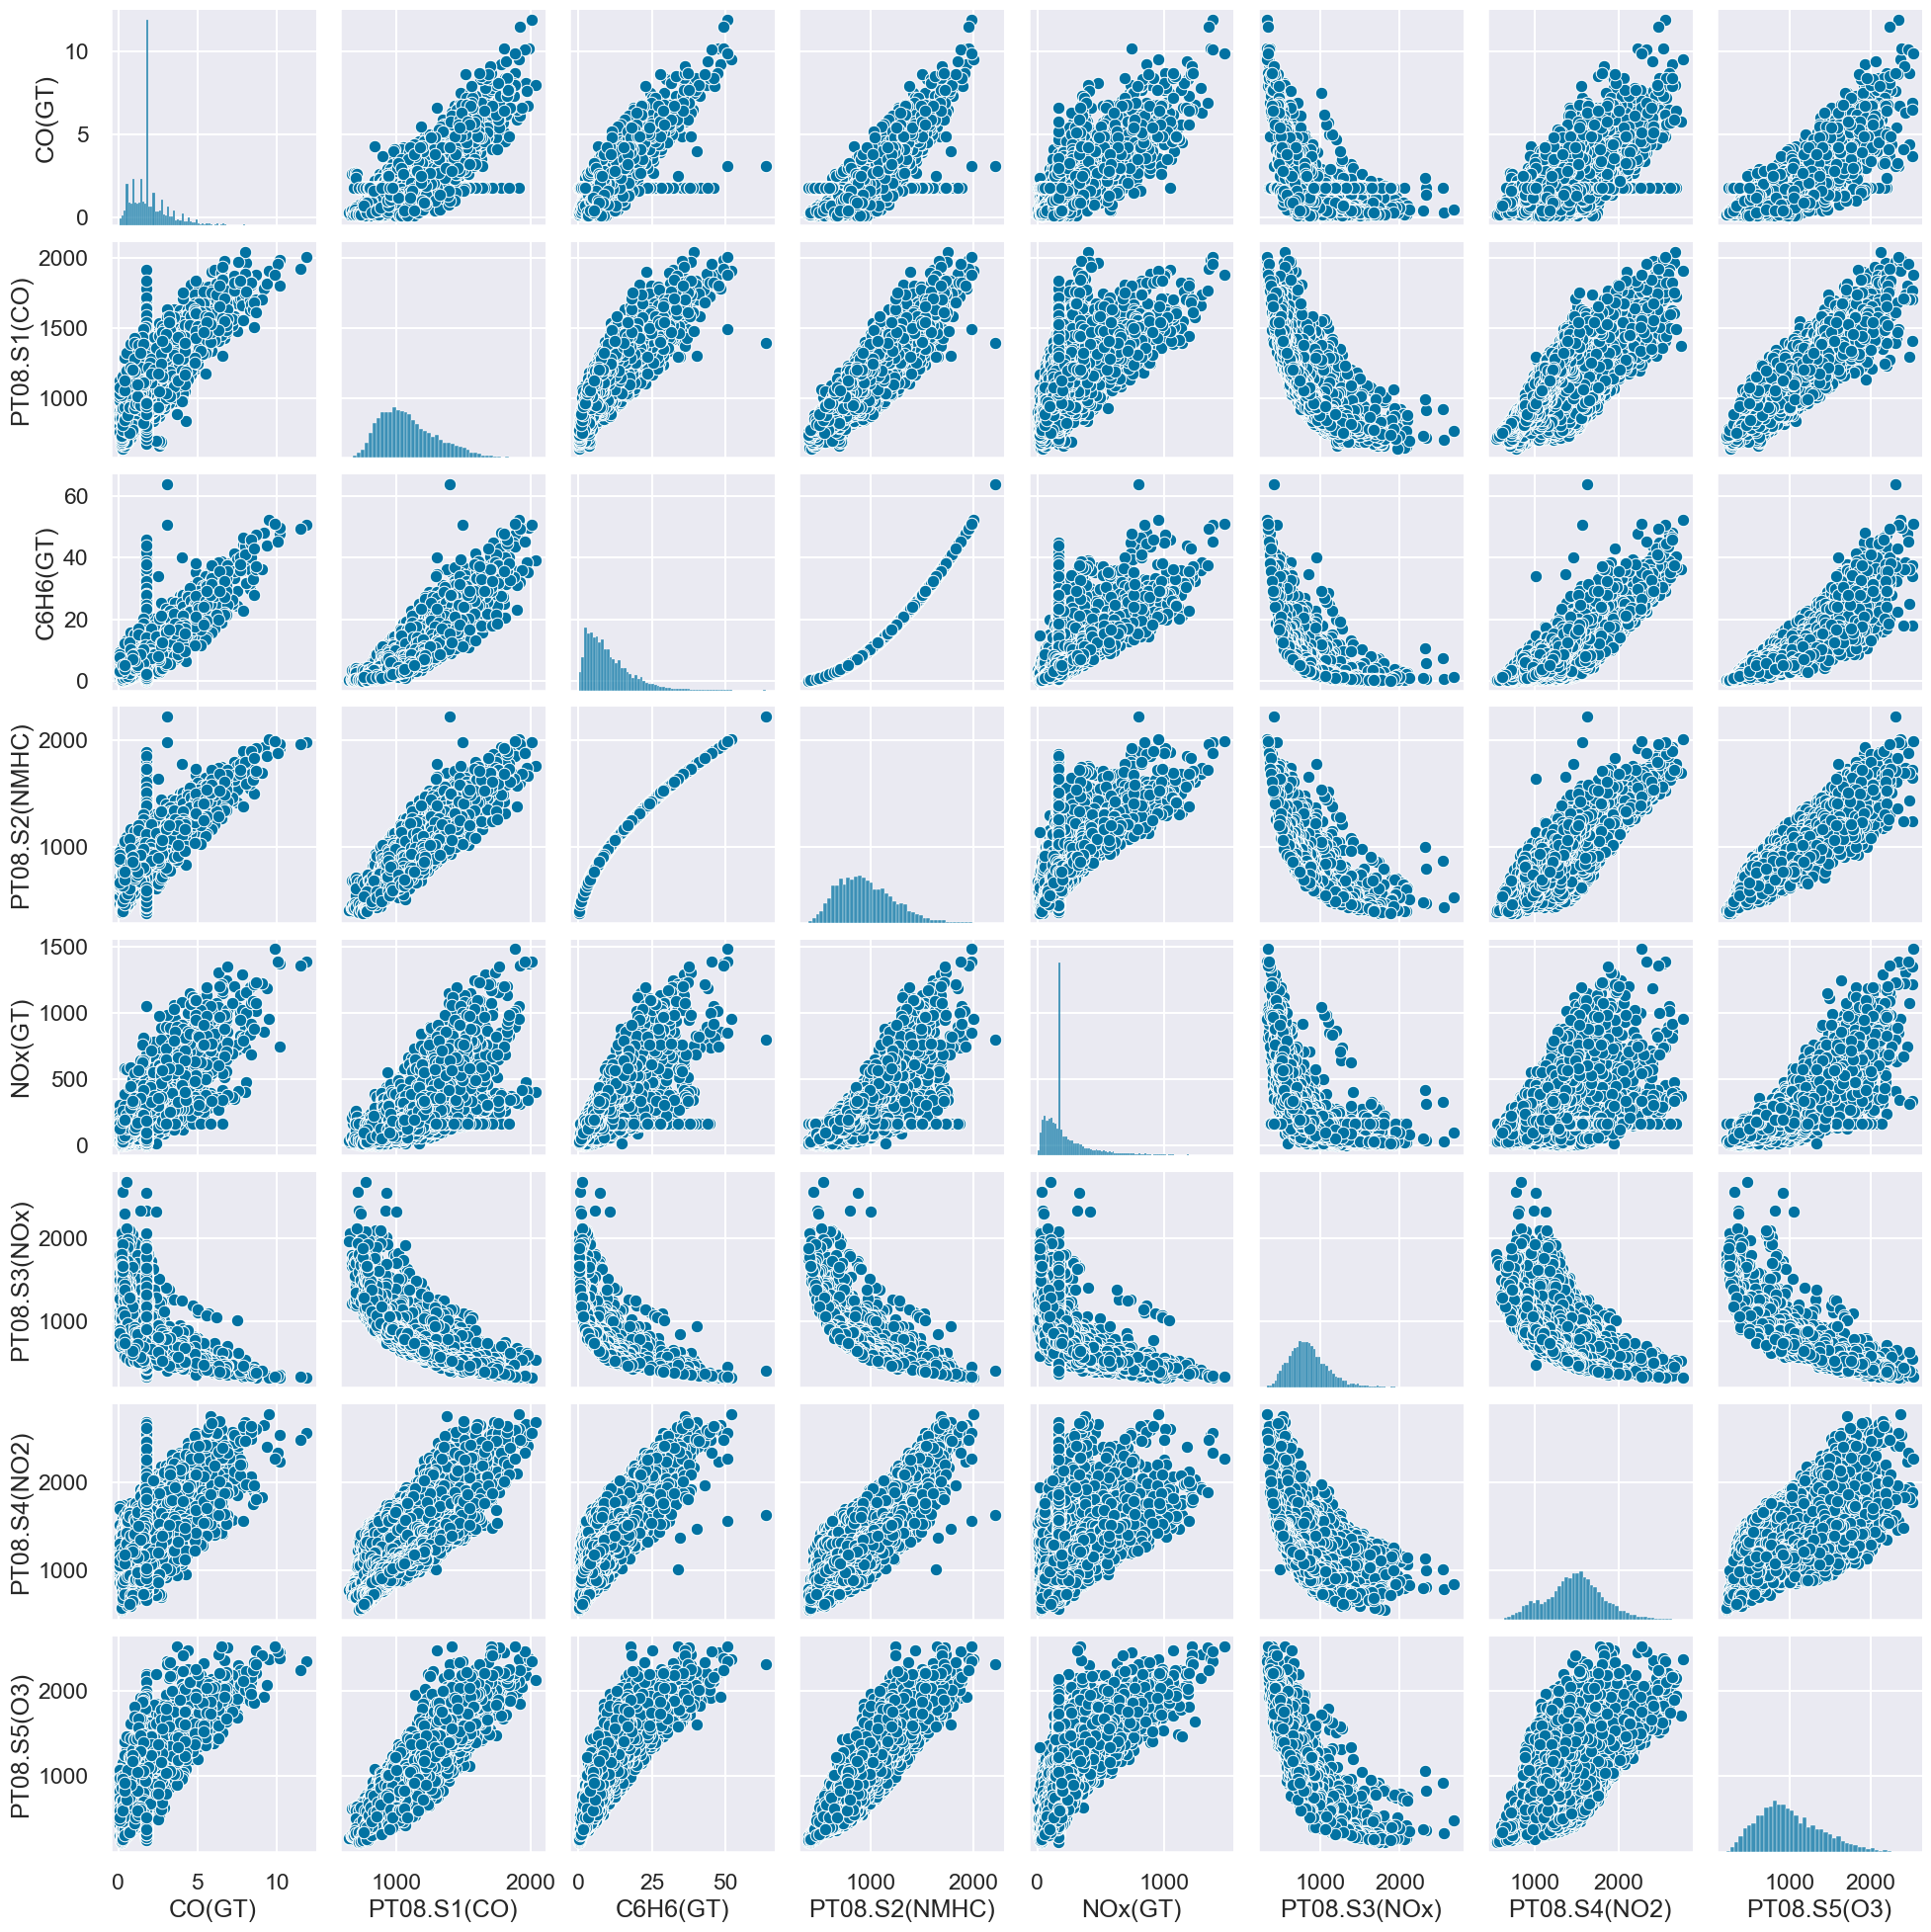

In [ ]:
a = sns.pairplot(data_top_corr)

Select important feature for futher analysis:

In [ ]:
top_corr_features = list(data_top_corr.columns)
top_corr_features.remove("C6H6(GT)")

In [ ]:
train_X, train_y = train.drop("C6H6(GT)", axis=1), train["C6H6(GT)"]

In [ ]:
train_selected_X = train_X[top_corr_features]

### Scaling

Since there are no dramatic outliers in data, the choice of best scaler relies to preserving relationship between variables which are highly correlated with target in dataset.  
To choose the best scaler let's draw a pairplot between _'PT08.S2(NMHC)'_ variable and _'C6H6(GT)'_(target)  
Two scalers to compare: _MinMax_scaler()_ and _Robust_scaler()_
Minmax scaler is more simple, susceptible to outliers and saves distribution of values.  
Robust scaler uses complex algorithms and outlier-prone.

In [ ]:
train_X_robust = pd.DataFrame(
    RobustScaler().fit_transform(train_selected_X), columns=train_selected_X.columns
)
train_X_minmax = pd.DataFrame(
    MinMaxScaler().fit_transform(train_selected_X), columns=train_selected_X.columns
)

__MinMax__ scaler works better for our data because it preserves high linear correlation between $(data)^2$ and target variable:

__Robust scaler and initial data__

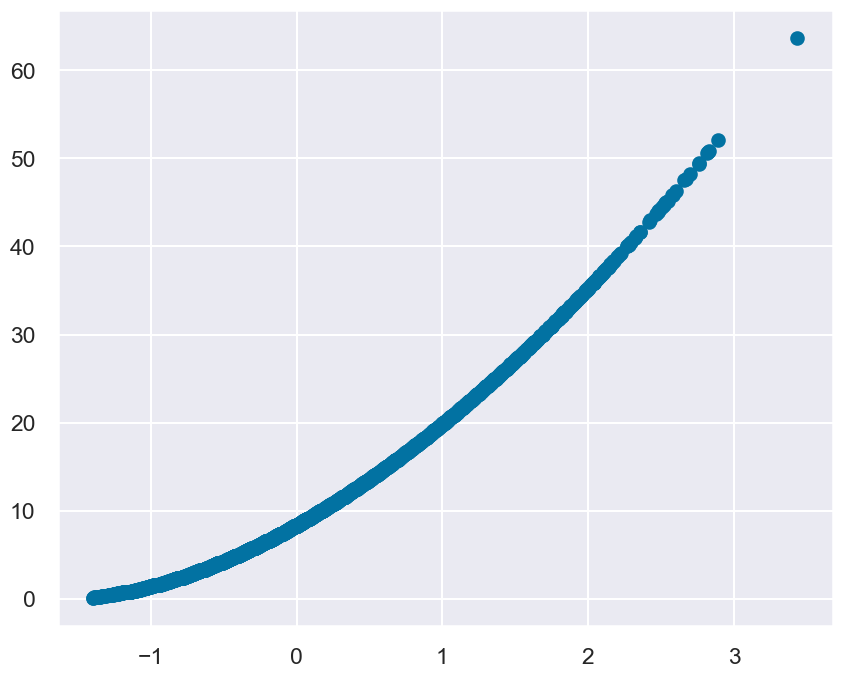

In [ ]:
plt.scatter(x=train_X_robust["PT08.S2(NMHC)"], y=train_y)

__MinMax scaler and initial data__

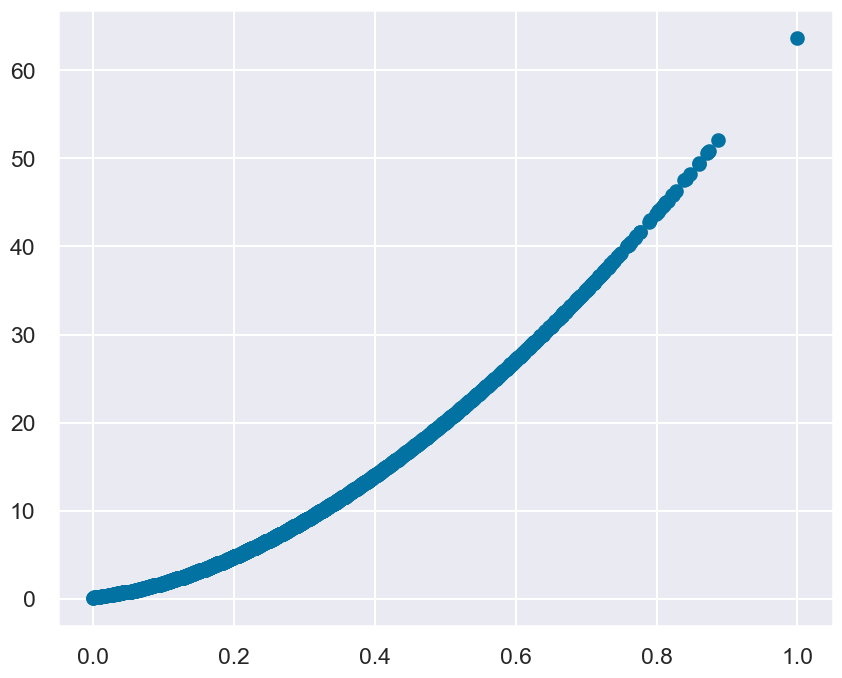

In [ ]:
plt.scatter(x=train_X_minmax["PT08.S2(NMHC)"], y=train_y)

__There's no big difference. To make this relationship linear let's try squared X:__

__Robust scaler and squared data__

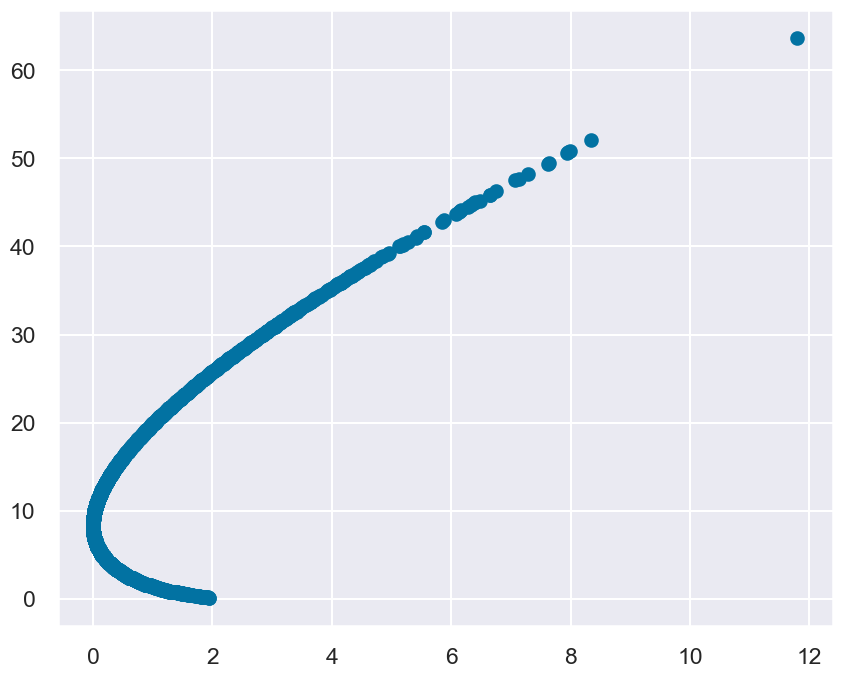

In [ ]:
plt.scatter(x=(train_X_robust["PT08.S2(NMHC)"]) ** 2, y=train_y)

__MinMax scaler and squared data__

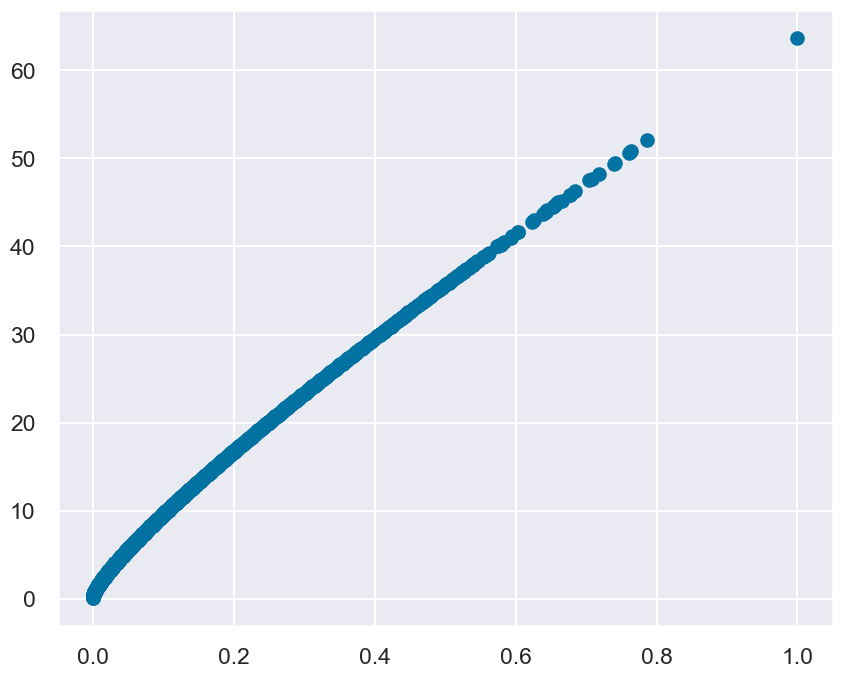

In [ ]:
plt.scatter(x=(train_X_minmax["PT08.S2(NMHC)"]) ** 2, y=train_y)

Clearly MinMax scaler wins.  

#### Create MinMax_scaler instance for future use:

In [ ]:
minmax_scaler = MinMaxScaler().fit(train_selected_X)

Data for future work: __train_X_minmax__

### CV split

Data is time-dependent, thus we have to use _TimeSeriesSplit_ for cross-validation:

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

### Baseline linear regression

In [ ]:
def CV(model, X, y, cv):
    fitted = model.fit(X, y)
    CV_score = np.mean(cross_val_score(estimator=fitted, X=X, y=y, cv=cv))
    print("Mean CV score for 5 folds = {}".format(CV_score))

__Cross-validation score for raw train data (no scaling, no features dropped):__

In [ ]:
CV(LinearRegression(), train_X, train_y, tscv)

Mean CV score for 5 folds = 0.9627417447676307


__Cross-validation score for scaled train data:__

In [ ]:
CV(LinearRegression(), train_X_minmax, train_y, tscv)

Mean CV score for 5 folds = 0.9624378820782293


__Let's compare with model with just one feature which is high correlated with _C6H6_:__

In [ ]:
CV(
    LinearRegression(),
    (train_X_minmax["PT08.S2(NMHC)"].values.reshape(-1, 1)) ** 2,
    train_y,
    tscv,
)

Mean CV score for 5 folds = 0.992347631994854


__Solution:__ the CV score is very high in case with just one variable. In real life it would be great, because we don't need to store a huge amount of data.  
But let's imagine we're on a kaggle competition and try to improve score with scaled train data (*train_X_minmax*).

### Polynomial features

Add 2 degree polynomial features:
* Fit PolynomialFeatures() instance
* Add features to train df
* Calculate cross-validation score

In [ ]:
poly = PolynomialFeatures(2).fit(train_X_minmax)
train_X_minmax_polynomial = pd.DataFrame(poly.transform(train_X_minmax))

In [ ]:
CV(LinearRegression(), train_X_minmax_polynomial, train_y, tscv)

Mean CV score for 5 folds = 0.9998971780056628


### Quality of predictions

__Test preprocessing__

* Fill NA with median values of train df
* select features with high correlation with target
* MinMax scale
* Add polynomial 2 degree features

In [ ]:
test = test.fillna(value=to_fill)

test_X, test_y = test.drop("C6H6(GT)", axis=1), test["C6H6(GT)"]
test_selected_X = test_X[top_corr_features]

test_scaled_X = pd.DataFrame(
    minmax_scaler.transform(test_selected_X), columns=test_selected_X.columns
)
test_X_polynomial = pd.DataFrame(poly.transform(test_scaled_X))

__Prediction quality__

To check quality of a model, I've chosen _RMSE_ as a general metric because it uses the same scale as initial data (not squared units) and _MAE_ to compare results and $R^2$ as a statistical metric because the number of features in data is not enormously high.

In [ ]:
def evaluate_model(train, val, tr_y, val_y, est):

    est.fit(train.values, tr_y)
    pred_val = est.predict(val.values)
    pred_train = est.predict(train.values)

    return (
        pd.DataFrame(
            {
                "train_RMSE": [np.sqrt(mean_squared_error(tr_y, pred_train))],
                "train_R2": [r2_score(tr_y, pred_train)],
                "val_RMSE": [np.sqrt(mean_squared_error(val_y, pred_val))],
                "val_R2": [r2_score(val_y, pred_val)],
                "train_MAE": [mean_absolute_error(tr_y, pred_train)],
                "val_MAE": [mean_squared_error(val_y, pred_val)],
            }
        ),
        train.columns,
    )

Best model we've obtained based on CV

In [ ]:
lin_model = LinearRegression().fit(train_X_minmax_polynomial, train_y)

In [ ]:
predictions = lin_model.predict(test_X_polynomial)
explained_variance_score(test_y, predictions)

0.9999308012785023

In [ ]:
scores, colnames = evaluate_model(
    train_X_minmax_polynomial, test_X_polynomial, train_y, test_y, LinearRegression()
)
scores

,train_RMSE,train_R2,val_RMSE,val_R2,train_MAE,val_MAE
0,0.054741,0.999947,0.060786,0.999918,0.040256,0.003695


### Feature importance

In [ ]:
def plot_importance(est, colnames, top_n=20):
    importance = pd.DataFrame({"abs_weight": np.abs(est.coef_), "feature": colnames})
    imp20 = importance.sort_values(by="abs_weight", ascending=False)[:top_n]
    sns.barplot(y="feature", x="abs_weight", data=imp20, orient="h")

The most important feature is $X2^2$, which is $PT08.S2(NMHC)^2$  
This is the one with the highest correlation, so big coefficient of this feature in model is not due overfitting, but acctually a valid result

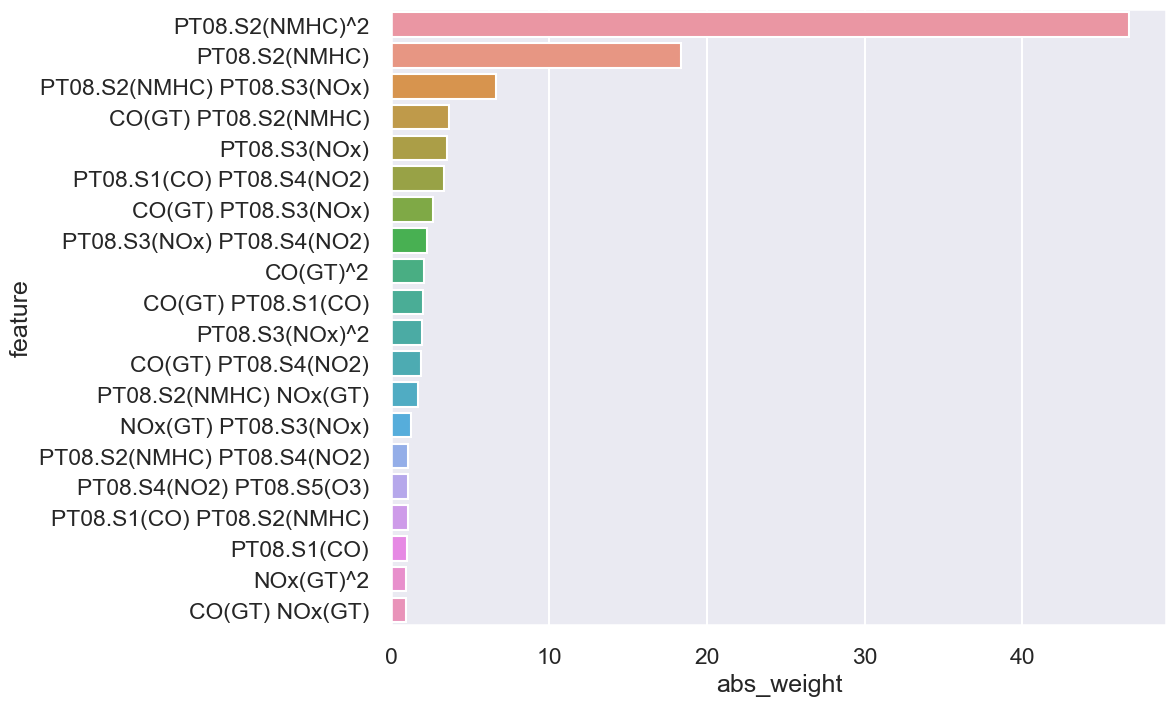

In [ ]:
plot_importance(lin_model, poly.get_feature_names_out())

In [ ]:
print("the most important feature is x2^2 = {}^2".format(test_X.columns[2]))

the most important feature is x2^2 = PT08.S2(NMHC)^2


### Hyperparameters tuning (Grid search), another types of linear regression

__Elastic Net__

In [ ]:
gs = GridSearchCV(
    ElasticNet(),
    {"alpha": np.linspace(0, 300, 10), "l1_ratio": np.arange(0, 1.1, 0.1)},
    n_jobs=-1,
    scoring=["neg_mean_squared_error", "r2"],
    refit="neg_mean_squared_error",
    cv=tscv,
)

In [ ]:
gs.fit(train_X_minmax_polynomial, train_y)

c:\Users\Emre_Ozden\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\Emre_Ozden\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': array([  0.        ,  33.33333333,  66.66666667, 100.        ,
       133.33333333, 166.66666667, 200.        , 233.33333333,
       266.66666667, 300.        ]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

Metrics for ElasticNet best classifier:

In [ ]:
scores, colnames = evaluate_model(
    train_X_minmax_polynomial, test_X_polynomial, train_y, test_y, gs.best_estimator_
)
scores

c:\Users\Emre_Ozden\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\Emre_Ozden\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


,train_RMSE,train_R2,val_RMSE,val_R2,train_MAE,val_MAE
0,0.0799,0.999887,0.121141,0.999676,0.055012,0.014675


__Result__: RMSE is higher than for LinearRegression() model

__Ridge regression__

In [ ]:
gs2 = GridSearchCV(
    Ridge(),
    {"alpha": np.linspace(0, 100, 10)},
    n_jobs=-1,
    scoring=["explained_variance", "neg_mean_squared_error", "r2"],
    refit="neg_mean_squared_error",
    cv=tscv,
)

In [ ]:
gs2.fit(train_X_minmax_polynomial, train_y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([  0.        ,  11.11111111,  22.22222222,  33.33333333,
        44.44444444,  55.55555556,  66.66666667,  77.77777778,
        88.88888889, 100.        ])},
             refit='neg_mean_squared_error',
             scoring=['explained_variance', 'neg_mean_squared_error', 'r2'])

In [ ]:
scores, colnames = evaluate_model(
    train_X_minmax_polynomial, test_X_polynomial, train_y, test_y, gs2.best_estimator_
)
scores

,train_RMSE,train_R2,val_RMSE,val_R2,train_MAE,val_MAE
0,0.054739,0.999947,0.060678,0.999919,0.040251,0.003682


__Result__: metrics are almost the same with those of LinearRegression()

### Residual analysis

In [ ]:
residuals_test = gs2.best_estimator_.predict(test_X_polynomial) - test_y
residuals_train = gs2.best_estimator_.predict(train_X_minmax_polynomial) - train_y

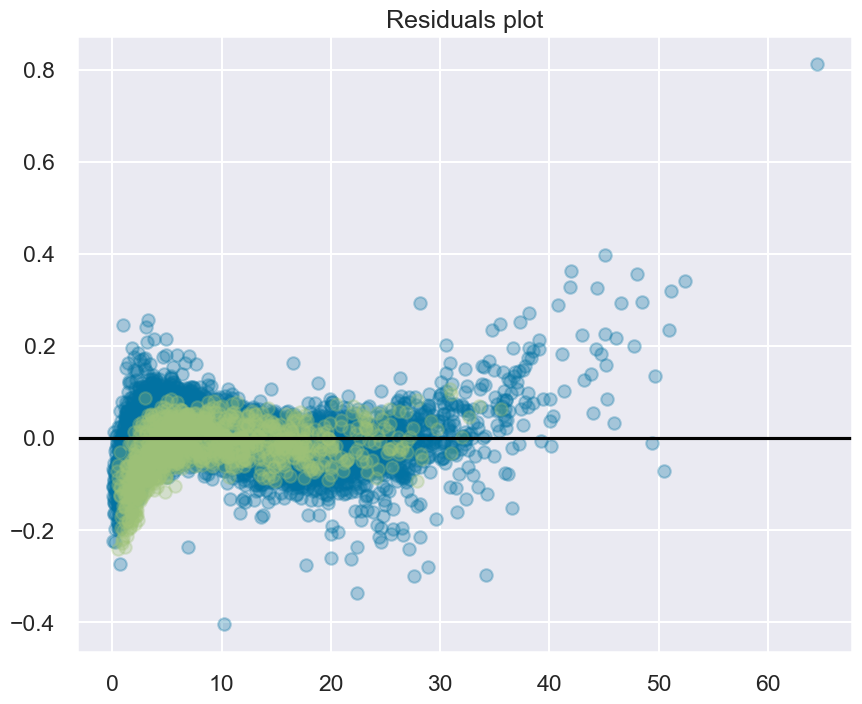

In [ ]:
plt.scatter(
    x=gs2.best_estimator_.predict(train_X_minmax_polynomial),
    y=residuals_train,
    alpha=0.3,
)
plt.scatter(
    x=gs2.best_estimator_.predict(test_X_polynomial), y=residuals_test, alpha=0.3
)
plt.axhline(y=0, c="black")
plt.title("Residuals plot")

__Result:__ Residuals have uneven bias, heteroskedasticity takes place. Seems like our model lacks variance.  
__Solution:__ Adding polynomial 3 degree features can help:

In [ ]:
poly = PolynomialFeatures(3).fit(train_X_minmax)
train_X_polynomial_3 = pd.DataFrame(poly.transform(train_X_minmax))

In [ ]:
test_X_polynomial_3 = pd.DataFrame(poly.transform(test_scaled_X))

In [ ]:
est = gs2.best_estimator_.fit(train_X_polynomial_3, train_y)

In [ ]:
residuals_test = est.predict(test_X_polynomial_3) - test_y
residuals_train = est.predict(train_X_polynomial_3) - train_y

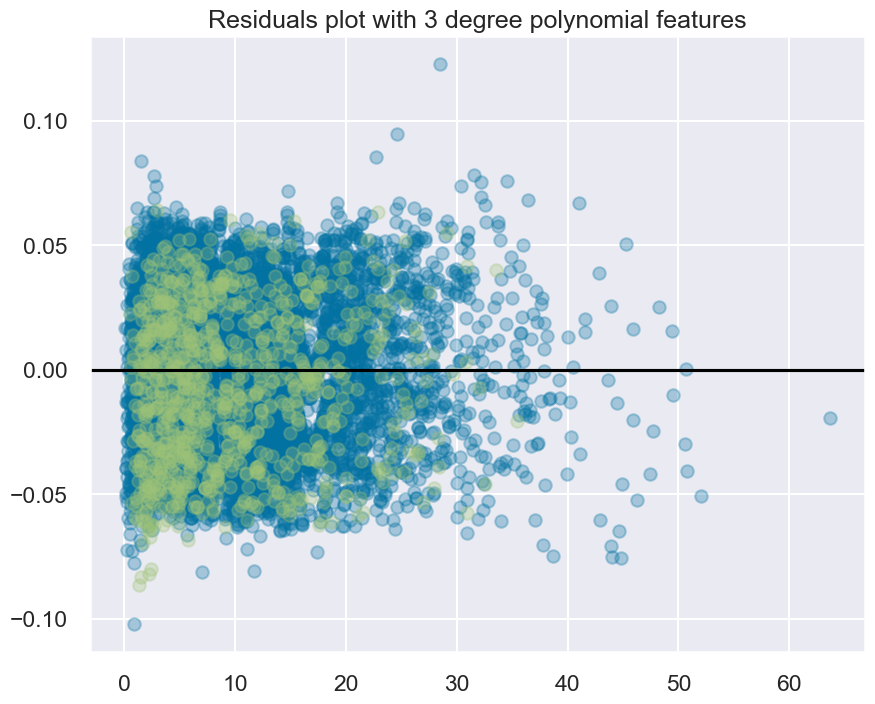

In [ ]:
plt.scatter(x=est.predict(train_X_polynomial_3), y=residuals_train, alpha=0.3)
plt.scatter(x=est.predict(test_X_polynomial_3), y=residuals_test, alpha=0.3)
plt.axhline(y=0, c="black")
plt.title("Residuals plot with 3 degree polynomial features")

Resiuals normality test:

In [ ]:
print(
    "Normality test p-value for train data = {}, for test data = {}".format(
        normaltest(residuals_train)[1], normaltest(residuals_test)[1]
    )
)

Normality test p-value for train data = 5.802485958675085e-239, for test data = 3.5595321741762986e-35


__Result__: With 3 degree polynomial features the picture is better, residuals are evenly distributed, but there are still no normality.

Metrics for model with 3 degree polynomial features:

In [ ]:
scores, colnames = evaluate_model(
    train_X_polynomial_3, test_X_polynomial_3, train_y, test_y, est
)
scores

,train_RMSE,train_R2,val_RMSE,val_R2,train_MAE,val_MAE
0,0.030173,0.999984,0.031496,0.999978,0.025635,0.000992
